# Sparklehorse - Der SQL-Chatbot der Magpie

## Vorbereitung der Arbeitsumgebung

In einem ersten Schritt definierne wir unser Arbeitsverzeichnis. 

In [ ]:
import os
os.getcwd()
os.chdir("c:/Users/mhu/Documents/gitHub/magpie_chatbot")
# Pfad Privatrechner
# os.chdir("c:/Users/Hueck/OneDrive/Dokumente/GitHub/magpie_langchain")

Lade Umgebungsvariablen (inkl. OpenAI-API-Key) und initialisiere den Chatbot mit dem Modell "gpt-4o" von OpenAI.

In [ ]:
from dotenv import load_dotenv
from langchain_openai import ChatOpenAI

load_dotenv()
llm = ChatOpenAI(model="gpt-4o")

  Im folgenden stellen wir Verbindung zur Magpie her. Wir schauen uns dan alle in der Magpie befindlichen Tabellen an. Schließlich wählen wir `view_daten_reichweite_menge` aus und speichern diese als Pandas Data Frame zur einfachen exploration der Datentabelle.

In [ ]:
import pandas as pd
from langchain_community.utilities import SQLDatabase
from langchain_community.agent_toolkits import SQLDatabaseToolkit 

db = SQLDatabase.from_uri("duckdb:///data/view_magpie.db") 

db.run("SHOW TABLES")

query = "SELECT * FROM view_daten_reichweite_menge;"
df = pd.read_sql(query, db._engine)
df

## Tools

### Standardisierte Langchain Tools

Wir intitalsieren ein standardisiertes Toolkit. Es stellt Funktionen bereit, um SQL-Queries über natürliche Sprache zu erzeugen und auszuführen. Wir lassen uns Namen und Funktion der standardisierten Tools anzeigen:

In [ ]:
toolkit = SQLDatabaseToolkit(db=db, llm=llm)

tools = toolkit.get_tools()

for tool in tools:
    print(f"Tool Name: {tool.name}")
    print(f"Description: {tool.description}")
    print("-" * 40)

Die Standardtools aus`SQLDatabaseToolkit`können also die folgenden Standardfunktionen übernehmen: 

- `sql_db_query`  
  Führt eine übergebene SQL-Abfrage aus. Gibt das Ergebnis oder eine Fehlermeldung zurück. Bei Fehlern wie „Unknown column“ sollte zuvor das Tabellenschema geprüft werden.

- `sql_db_schema`  
  Gibt das Schema (Spaltennamen und -typen) sowie Beispielzeilen für angegebene Tabellen zurück. Vorher sollte geprüft werden, ob die Tabellen existieren.

- `sql_db_list_tables`  
  Listet alle Tabellen in der verbundenen Datenbank auf.

- `sql_db_query_checker`  
  Prüft eine SQL-Abfrage auf syntaktische Korrektheit, bevor sie mit sql_db_query ausgeführt wird. Sollte immer vorher verwendet werden.


### Maßgeschneiderte Langchain Tools

#### Retriever `rt_beschr_variable`

`rt_beschr_variable` erlaubt die semantischen Suche über Werte aus einer Datenbankspalte. 

1. Wir sammeln sämtliche Unique Werte aus `beschr_variable` und wandeln diese mit OpenAIs Embeddings-Methdode `text-embedding-3-large` in Embeddings um. Die werden in einen Vektorstore gesichert.
2. Der Vektorstore wird in einen Retriever umgewandelt, der bei einer Anfrage die 5 ähnlichsten Begriffe zurückgibt.
3. Schließlich wird mit `create_retriever_tool` ein Tool erzeugt, das den Retriever kapselt. Dieses Tool kann von Sparklehorse genutzt werden, um Benutzereingaben mit unsicherer Schreibweise oder unvollständigen Begriffen mit den tatsächlichen Werten in der Datenbank abzugleichen.

In [ ]:
from langchain_openai import OpenAIEmbeddings
from langchain_core.vectorstores import InMemoryVectorStore
from langchain.agents.agent_toolkits import create_retriever_tool
import ast
import re

##################################################################
# Generiere `rt_beschr_variable`
##################################################################

def query_as_list(db, query):
    res = db.run(query)
    res = [el for sub in ast.literal_eval(res) for el in sub if el]
    res = [re.sub(r"\b\d+\b", "", string).strip() for string in res]
    return list(set(res))


beschr_variable = query_as_list(db, "SELECT variable_beschr FROM view_daten_reichweite_menge")
embeddings = OpenAIEmbeddings(model="text-embedding-3-large")
vector_store = InMemoryVectorStore(embeddings)
_ = vector_store.add_texts(beschr_variable)

retriever_beschr_variable  = vector_store.as_retriever(search_kwargs={"k": 5})

description = (
    "Verwenden, um Werte für Filterabfragen nachzuschlagen. Die Eingabe ist eine ungefähre Schreibweise "
    "eines Eigennamens, die Ausgabe sind gültige Eigennamen. Verwende den Begriff, der der Eingabe am ähnlichsten ist."
)

rt_beschr_variable = create_retriever_tool(
    retriever_beschr_variable,
    name="rt_beschr_variable",
    description=description,
)

Wir testen nun den Retriever:

In [108]:
def print_clean_result(result):
    print("\n".join(result.split("\n\n")))

result = rt_beschr_variable.invoke("Studienanfänger ohne Abitur")

print_clean_result(result)

Studienabsolventen ohne Abitur
Anzahl der Studienanfänger ohne Abitur
Anteil der Studienanfänger ohne Abitur
Anteil der Studienabsolventen ohne Abitur
Studienabsolventen Bildungsausländer


#### Retriever `rt_reichweite_variable` & `rt_werteinheit_variable`

Wir bauen einen baugleichen Retriever nun noch für die Variablen `reichweite_beschr_list` und `wert_einheit`. 

In [59]:
##################################################################
# Generiere `rt_reichweite_variable`
##################################################################

reichweite_variable = query_as_list(db, "SELECT reichweite_beschr_list FROM view_daten_reichweite_menge")

embeddings = OpenAIEmbeddings(model="text-embedding-3-large")

vector_store = InMemoryVectorStore(embeddings)

_ = vector_store.add_texts(reichweite_variable)

retriever_reichweite_variable = vector_store.as_retriever(search_kwargs={"k": 5})

description = (
"Verwenden, um Werte für Filterabfragen nachzuschlagen. Die Eingabe ist eine ungefähre Schreibweise "
"eines Eigennamens, die Ausgabe sind gültige Eigennamen. Verwende den Begriff, der der Suche am ähnlichsten ist."
)

rt_reichweite_variable = create_retriever_tool(
    retriever_reichweite_variable,
    name="rt_reichweite_variable",
    description=description,
)

##################################################################
# Generiere `rt_beschr_wert_einheit`
##################################################################

werteinheit_variable = query_as_list(db, "SELECT wert_einheit FROM view_daten_reichweite_menge")

embeddings = OpenAIEmbeddings(model="text-embedding-3-large")

vector_store = InMemoryVectorStore(embeddings)

_ = vector_store.add_texts(werteinheit_variable)

retriever_beschr_wert_einheit = vector_store.as_retriever(search_kwargs={"k": 5})

description = (
    "Verwenden, um Werte für Filterabfragen nachzuschlagen. Die Eingabe ist eine ungefähre Schreibweise "
    "eines Eigennamens, die Ausgabe sind gültige Eigennamen. Verwende den Begriff, der der Suche am ähnlichsten ist."
)

rt_werteinheit_variable = create_retriever_tool(
    retriever_beschr_wert_einheit,
    name="rt_beschr_wert_einheit",
    description=description,
)

In [104]:
result = rt_reichweite_variable.invoke("Wie hoch war die Anzahl von Studierenden ohne Abitur 2006?")

print_clean_result(result)

Sonstiges Orientierungsstudium
Hochschulsektor | Deutschland
Berlin | Schulfach Mathematik | . Schulklasse | Ohne Migrationshintergrund
Deutschland | Schulfach Mathematik | . Schulklasse | Niedriger sozioökonomischer Status (ISEI)
Sonstige Hochschule | Deutschland


In [61]:
result = rt_werteinheit_variable.invoke("Wie hoch war die Anzahl von Studierenden ohne Abitur 2006?")
print_clean_result(result)

Anzahl
Prozent
in Tsd. Euro
Punkte
Mittelwert


In [109]:
from langchain_core.tools import tool
from langchain.prompts import PromptTemplate
from langchain.chains import LLMChain

@tool
def variable_beschr(user_question: str) -> str:
    """
    Nutzt ein LLM, um aus der Frage eine passende Variable zu extrahieren,
    und gibt dann die exakte Variable aus der Datenbank zurück.
    """

    extract_prompt = PromptTemplate(
        input_variables=["frage"],
        template="""
        Die folgende Frage bezieht sich auf eine statistische Kennzahl.
        Extrahiere bitte eine passende Variable, die in einer Datenbankabfrage verwendet werden kann. Extrahiere ebenfalls, wenn eine Anzahl, oder Anteil gewünscht ist.

        Beispielausgabe: 'Anteil Studienanfänger ohne Abitur', 'Drittmittel DFG', 'Technisches FuE-Personal'

        Frage: "{frage}"

        Gib nur eine Variable zurück.
        """
    )

    variable_chain = extract_prompt | llm
    extracted_variable = variable_chain.invoke({"frage": user_question}).content.strip()

    # Übergabe an Retriever zur semantischen Validierung
    print(extracted_variable)
    docs = retriever_beschr_variable.get_relevant_documents(extracted_variable)
    if not docs:
        return "Error: Keine passende Variable gefunden."

    best_match = docs[0].page_content.strip()
    query = f"""
        SELECT variable_beschr 
        FROM view_daten_reichweite_menge 
        WHERE variable_beschr = '{best_match}' 
        LIMIT 1;
    """
    result = db.run_no_throw(query)
    return result if result else "Error: Keine passende Variable gefunden."

@tool
def get_reichweite_beschr_list(user_question: str) -> str:
    """
    Nutzt ein LLM, um aus der Frage eine wahrscheinliche Reichweite zu extrahieren.
    Fällt zurück auf 'Deutschland', wenn keine Region erkennbar ist.
    Die Reichweite wird anschließend mit dem Retriever abgeglichen.
    """

    extract_prompt = PromptTemplate(
        input_variables=["frage"],
        template="""
        Extrahiere eine Reichweite. Eine Reichweite ist eine Gruppierungsmerkmal eines Datenpunktes, wie z.B. eine Region, 
        eine Organisation, eine Hochschule, Geschlecht oder Branchen oder Sektoren usw.

        Falls nichts genannt wird oder nur allgemein gefragt ist, gib 'Deutschland' zurück.

        Frage: "{frage}"

        Antwort (nur eine Reichweite oder 'Deutschland'):
        """
    )

    reichweite_chain = extract_prompt | llm
    reichweite = reichweite_chain.invoke({"frage": user_question}).content.strip()

    # Übergabe an Retriever zur Validierung/Matching
    matches = rt_reichweite_variable.invoke(reichweite).split("\n")
    best_match = matches[0].strip()

    query = f"""
        SELECT reichweite_beschr_list 
        FROM view_daten_reichweite_menge 
        WHERE reichweite_beschr_list = '{best_match}' 
        LIMIT 1;
    """
    result = db.run_no_throw(query)
    return result if result else "Error: Keine passende Variable gefunden."


# @tool
# def get_wert_einheit_id(user_question: str) -> str:
#     """Sucht in der Tabelle 'wert_einheit' nach einer passenden ID basierend auf der Beschreibung."""
#     query = f"SELECT id FROM wert_einheit WHERE beschr LIKE '%{description}%' LIMIT 1;"
#     result = db.run_no_throw(query)
#     return result if result else "Error: Keine passende Werteinheit gefunden."

 


tools.extend([variable_beschr, get_reichweite_beschr_list])

In [110]:
test_input = "Wie viele Studienanfänger ohne Abitur gab es 2016?"
output = variable_beschr(test_input)
print(output)

'Anzahl Studienanfänger ohne Abitur'
[('Anzahl der Studienanfänger ohne Abitur',)]


In [ ]:
from langchain import hub

prompt_template = hub.pull("langchain-ai/sql-agent-system-prompt")

assert len(prompt_template.messages) == 1, "Die Anzahl der Nachrichten im Template ist nicht 1!"
# Bearbeite die bestehende Nachricht, indem du Text hinzufügst
prompt_template.messages[0].prompt.template += (
    "\nYou are Sparklehorse, a chatbot for the Stifterverband organization. "
    "Your primary task is to answer questions related to the Magpie database."
)

prompt_template.messages[0].pretty_print()

In [ ]:
system_message = prompt_template.format(
    dialect=db.dialect, 
    top_k=5
)

print(system_message)

In [92]:
from langchain_core.messages import HumanMessage
from langgraph.prebuilt import create_react_agent

# Systemnachricht mit extra Anweisungen
suffix = (
    "Bevor du eine SQL-Abfrage generierst, beachte bitte folgende Regeln strikt:\n"
    "1. Nutze das Tool `variable_beschr`, um die korrekte Variable aus der Nutzerfrage zu bestimmen. Verwende ausschließlich den exakten Rückgabewert dieses Tools für `variable_beschr` in der SQL-Abfrage.\n"
    "2. Nutze das Tool `get_reichweite_beschr_list`, um die passende Reichweite zu ermitteln. Verwende ausschließlich den Rückgabewert dieses Tools für `reichweite_beschr_list` in der SQL-Abfrage.\n"
    "3. Verwende **niemals** andere Felder wie `tag_list` oder `LIKE`-Abfragen. Nutze **immer exakte Vergleiche** mit `=`.\n"
    "4. Verwende ausschließlich die Tabelle `view_daten_reichweite_menge` für alle Abfragen.\n"
    "5. Falls ein Jahr in der Frage genannt wird, filtere mit `date_part('year', zeit_start) = <Jahr>`.\n"
    "6. Berücksichtige die Spalte `wert_einheit`, z. B. 'in Tsd. Euro', 'Anzahl', 'Prozent', 'VZÄ', 'Mitarbeiter'.\n"
    "7. Gib immer die finale SQL-Abfrage vollständig aus und erkläre sie. Rate niemals IDs oder Werte.\n"
    "8. Falls keine passende Variable oder Reichweite gefunden wurde, gib eine klare Fehlermeldung und begründe sie.\n"
    "9. Stelle sicher, dass Antworttext und SQL-Abfrage immer auf den gleichen `variable_beschr`- und `reichweite_beschr_list`-Werten basieren, um Konsistenz zu gewährleisten."
)

 

system = f"{system_message}\n\n{suffix}"

# Neuen ReAct-Agent erstellen mit den vollständigen Tools
agent_executor = create_react_agent(llm, tools, state_modifier=system)


In [111]:
# Testanfrage an den Agenten
question = "Wieviele Vollzeitäquivalente gab es im Technische FuE-Personal 2021??"

for step in agent_executor.stream(
    {"messages": [HumanMessage(content=question)]}, 
    stream_mode="values"
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

Wieviele Vollzeitäquivalente gab es im Technische FuE-Personal 2021??
================================== Ai Message ==================================
Tool Calls:
  variable_beschr (call_57t3AZgSyjDgeWZ85CRSR0x7)
 Call ID: call_57t3AZgSyjDgeWZ85CRSR0x7
  Args:
    user_question: Wieviele Vollzeitäquivalente gab es im Technische FuE-Personal 2021?
  get_reichweite_beschr_list (call_wOjTGkLIuDVMOFd7ViZwkt2i)
 Call ID: call_wOjTGkLIuDVMOFd7ViZwkt2i
  Args:
    user_question: Wieviele Vollzeitäquivalente gab es im Technische FuE-Personal 2021?
================================= Tool Message =================================
Name: get_reichweite_beschr_list

[('Deutschland',)]
================================== Ai Message ==================================
Tool Calls:
  sql_db_query_checker (call_7CojUQEFVKxXEV5ktqGPRXE5)
 Call ID: call_7CojUQEFVKxXEV5ktqGPRXE5
  Args:
    query: SELECT reichweite_beschr, varia

In [94]:
from langchain.schema import HumanMessage

questions = [
    "Wie hoch waren die Drittmittel-Ausgaben von der EU 2020?",
    "Wie hoch waren die Drittmittel-Ausgaben von der EU 2020 in Deutschland?",
    "Wie viele Studienabsolventen im Weiterbildungsstudium gab es 2019?",
    "Wie hoch waren die Drittmittel von von der DFG-Exzellenzstrategie 2020 an Theologische Hochschulen?",
    "Wie hoch waren die Drittmittel insgesamt der Medizinische Hochschule Brandenburg Theodor Fontane (MHB) 2020?",
    "Wie hoch waren die Drittmittel von von der DFG-Exzellenzstrategie in Hessen 2020?",
    "Wieviele Vollzeitäquivalente gab es im Technische FuE-Personal 2021?",
    "Wie viele Studienanfänger für ein duales Studium gab es 2019?",
    "Wie viele Studienanfänger ohne Abitur gab es 2019 im Saarland?",
    "Wie viele Studienanfänger in einem dualen Studium gab es 2019 in Berlin?",
    "Wie viele Studienanfänger ohne Abitur gab es 2016?"
]

for question in questions:
    result = agent_executor.invoke({"messages": [HumanMessage(content=question)]})
    messages = result["messages"]
    antwort = messages[-1].content
    sql_query = next(
        (m.content for m in messages if "SELECT" in m.content.upper()), 
        "SQL-Abfrage nicht gefunden."
    )
    print(f"\nFrage: {question}\nAntwort: {antwort}\nSQL: {sql_query}")


Frage: Wie hoch waren die Drittmittel-Ausgaben von der EU 2020?
Antwort: Entschuldigung, es scheint, dass für die Anfrage "Drittmittel-Ausgaben von der EU im Jahr 2020" keine Daten vorhanden sind. Möglicherweise gibt es in der Datenbank keine entsprechenden Einträge oder die Daten sind noch nicht erfasst.
SQL: ```sql
SELECT wert, wert_einheit 
FROM view_daten_reichweite_menge 
WHERE variable_beschr = 'Drittmittel von der EU' 
AND reichweite_beschr_list = 'Europäische Wirtschaft' 
AND date_part('year', zeit_start) = 2020 
LIMIT 5;
```

Frage: Wie hoch waren die Drittmittel-Ausgaben von der EU 2020 in Deutschland?
Antwort: Die Drittmittel-Ausgaben von der EU in Deutschland im Jahr 2020 betrugen etwa 874.467 Tausend Euro.
SQL: ```sql
SELECT wert, wert_einheit FROM view_daten_reichweite_menge WHERE variable_beschr = 'Drittmittel von der EU' AND reichweite_beschr_list = 'Europäische Wirtschaft' AND date_part('year', zeit_start) = 2020 LIMIT 5
```

Frage: Wie viele Studienabsolventen im Wei

In [96]:
from langgraph.prebuilt import create_react_agent
graph = create_react_agent(llm, tools, state_modifier=system)


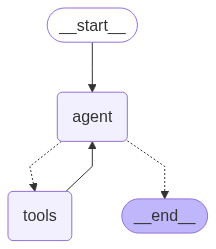

In [101]:
graph